In [ ]:
import pandas as pd
from PIL import Image
from shapely.geometry import box as shapely_box
from shapely.affinity import scale

# Load the .pkl file
#df = pd.read_pickle(r"C:\Users\gnvca\OneDrive\Desktop\JP\Model_Train.pkl")
#df = pd.read_pickle(r"C:\Users\gnvca\OneDrive\Desktop\JP\Model_Val.pkl")
df = pd.read_csv(r"C:\Users\gnvca\OneDrive\Desktop\JP\Test.csv")
image_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\images"

df.head()

In [2]:
def scale_polygon(polygon, scale=1.15):
    """Scales a polygon outward from its centroid."""
    xs, ys = zip(*polygon)
    cx, cy = sum(xs) / len(xs), sum(ys) / len(ys)
    return [(cx + scale * (x - cx), cy + scale * (y - cy)) for x, y in polygon]

def polygon_to_yolo_bbox(polygon, img_width, img_height):
    """Converts polygon to YOLO normalized bbox."""
    xs, ys = zip(*polygon)
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    
    x_center = ((x_min + x_max) / 2) / img_width
    y_center = ((y_min + y_max) / 2) / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    
    return x_center, y_center, width, height

In [ ]:
import os

#label_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\labels\val"  # or val, depending on the split
#label_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\labels\train"  # or val, depending on the split

os.makedirs(label_dir, exist_ok=True)

image_width, image_height = 600, 600  # Replace with actual size if dynamic

for idx, row in df.iterrows():
    label_lines = []

    # Process boilers (class 0)
    for poly in row['polygons_boil']:
        scaled_poly = scale_polygon(poly, scale=1.15)
        x, y, w, h = polygon_to_yolo_bbox(scaled_poly, image_width, image_height)
        label_lines.append(f"0 {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    # Process panels (class 1)
    for poly in row['polygons_pan']:
        scaled_poly = scale_polygon(poly, scale=1.15)
        x, y, w, h = polygon_to_yolo_bbox(scaled_poly, image_width, image_height)
        label_lines.append(f"1 {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    # Save to .txt file
    label_path = os.path.join(label_dir, f"{row['img_id']}.txt")
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

In [4]:
df.head()

,ID,img_origin,placement
0,ID00qprY,D,roof
1,ID01AciUc,D,roof
2,ID0328D,D,roof
3,ID05WxObCFTs9,D,roof
4,ID06AdCmLMlkO,S,S-unknown


In [5]:
import os
import shutil
import pandas as pd

# Load the training DataFrame
df_train = pd.read_pickle(r"C:\Users\gnvca\OneDrive\Desktop\JP\Model_Train.pkl")
df_val = pd.read_pickle(r"C:\Users\gnvca\OneDrive\Desktop\JP\Model_Val.pkl")
# Paths
image_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\images"  # Folder with original images
output_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\images\test"  # Destination folder
os.makedirs(output_dir, exist_ok=True)

# Copy each image
for img_id in df['ID']:
    src_path = os.path.join(image_dir, f"{img_id}.jpg")
    dst_path = os.path.join(output_dir, f"{img_id}.jpg")

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
    else:
        print(f"⚠️ Warning: Image not found: {src_path}")


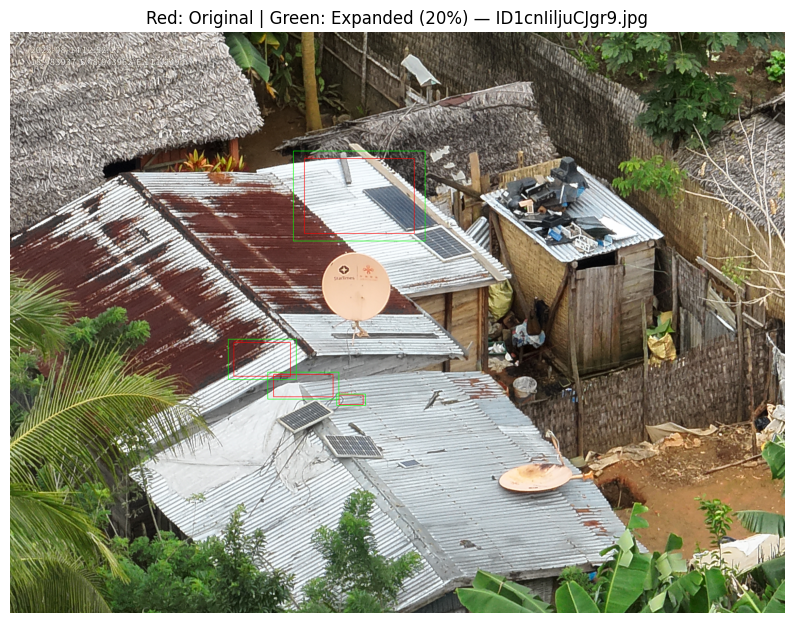

C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\images\train\\ID1cnIiljuCJgr9.jpg


In [18]:
import cv2
import os
import matplotlib.pyplot as plt
from shapely.geometry import box as shapely_box
from shapely.affinity import scale

# Paths
image_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\images\train\\"
label_dir = r"C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\labels\train\\"
# Pick a sample image
sample_image = os.listdir(image_dir)[0]
image_path = os.path.join(image_dir, sample_image)
label_path = os.path.join(label_dir, sample_image.replace(".jpg", ".txt"))

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

# Pick a sample image
sample_image = os.listdir(image_dir)[110]
image_path = os.path.join(image_dir, sample_image)
label_path = os.path.join(label_dir, sample_image.replace(".jpg", ".txt"))

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

# Draw both original and expanded boxes
with open(label_path, "r") as f:
    for line in f:
        cls, x_c, y_c, bw, bh = map(float, line.strip().split())

        # Convert YOLO (normalized) to pixel coordinates
        x_c *= w
        y_c *= h
        bw *= w
        bh *= h

        # Original box corners
        x1 = x_c - bw / 2
        y1 = y_c - bh / 2
        x2 = x_c + bw / 2
        y2 = y_c + bh / 2

        # Draw original (red)
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(image, f"Class {int(cls)}", (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)

        # Expand using Shapely
        poly = shapely_box(x1, y1, x2, y2)
        poly_scaled = scale(poly, xfact=1.2, yfact=1.2, origin='center')
        x1_new, y1_new, x2_new, y2_new = map(int, poly_scaled.bounds)

        # Clip to image dimensions
        x1_new = max(0, min(w - 1, x1_new))
        y1_new = max(0, min(h - 1, y1_new))
        x2_new = max(0, min(w - 1, x2_new))
        y2_new = max(0, min(h - 1, y2_new))

        # Draw expanded box (green)
        cv2.rectangle(image, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 2)

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(f"Red: Original | Green: Expanded (20%) — {sample_image}")
plt.axis("off")
plt.show()
print(image_path)

In [25]:
df.head()

,img_id,img_origin,img_placement,nr_boil,polygons_boil,nr_pan,polygons_pan
0,IDUXSjTNlUQ59,D,openspace,[],[],"[14, 16]","[[(228.0551181102362, 277.6509186351706), (231..."
1,IDln9t3L,D,roof,[],[],[2],"[[(263.552, 259.584), (316.032, 237.056), (344..."
2,IDdLAJld1z,D,roof,"[1, 1, 1, 1]","[[(313.9878787878788, 384.1294236602629), (339...",[],[]
3,ID6g6IV,D,roof,[],[],[2],"[[(246.784, 171.17866666666666), (283.648, 156..."
4,IDrxyCyN,S,S-unknown,[1],"[[(203.37777777777777, 235.99198396793588), (1...",[],[]


C:\Users\gnvca\AppData\Local\Temp\ipykernel_85232\107819931.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


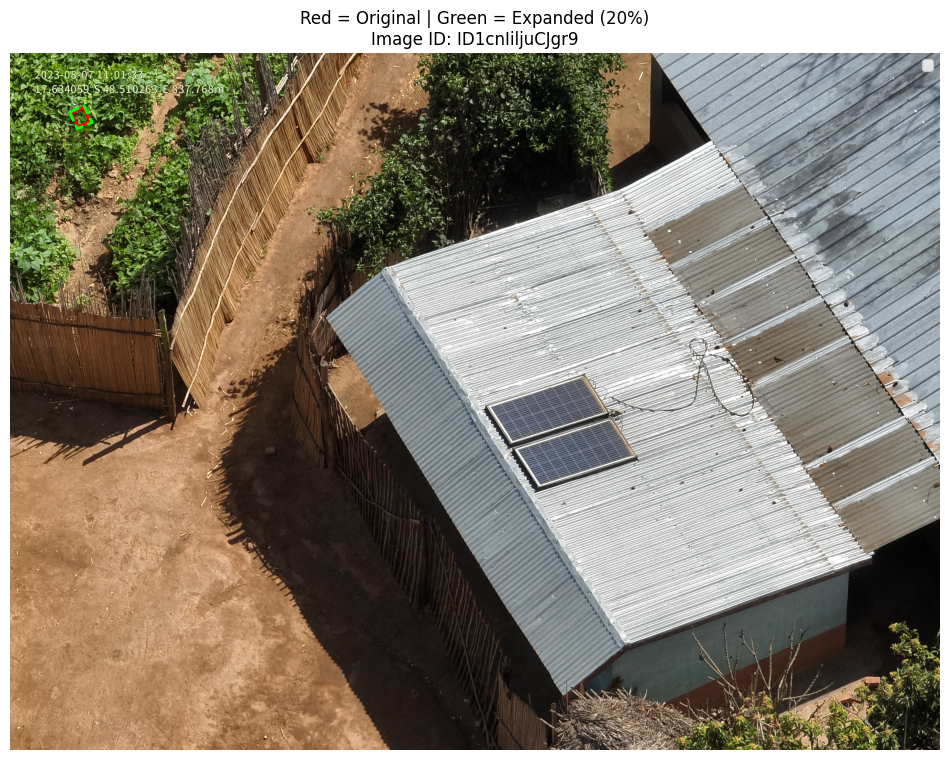

In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon
from shapely.affinity import scale
import os

# Load data
df = pd.read_pickle("Model_Train.pkl")
row = df[df["img_id"] == "IDln9t3L"].iloc[0]

# Adjust if your image extension is different (e.g. .png)
image_path = r"C:\Users\gnvca\OneDrive\Desktop\JP\model03S\dataset\images\train\IDln9t3L.jpg"
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")

# Load and prepare image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Start plotting
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)

# Combine both sets of polygons
all_polygons = [("boil", poly) for poly in row["polygons_boil"]] + \
               [("pan", poly) for poly in row["polygons_pan"]]

for cls, points in all_polygons:
    # Original polygon
    poly_orig = Polygon(points)
    if not poly_orig.is_valid or poly_orig.area == 0:
        continue

    # Expanded polygon (20% scale)
    poly_scaled = scale(poly_orig, xfact=1.2, yfact=1.2, origin='center')

    # Draw original in red
    x, y = poly_orig.exterior.xy
    ax.plot(x, y, color='red', linewidth=2, label='original' if cls == "boil" else "")

    # Draw expanded in green
    x2, y2 = poly_scaled.exterior.xy
    ax.plot(x2, y2, color='lime', linestyle='--', linewidth=2, label='expanded' if cls == "boil" else "")

# Set title and legend
ax.set_title("Red = Original | Green = Expanded (20%)\nImage ID: ID1cnIiljuCJgr9")
ax.axis("off")
plt.legend(loc='upper right')
plt.show()
